In [1]:
%reload_ext autoreload
%autoreload 2

## import packages

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
import random
from matplotlib.ticker import AutoMinorLocator
import copy

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## plotting defaults

In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## load replay data

In [4]:
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7'
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path,pre_task_post=True)

## run main analysis

In [5]:
def leave_one_out_score(results, direction, idx_replay):
    """
    Leave one out score for a given direction.
    Inputs:
        results: dict of results from replay_run.run_replay
        direction: string, 'inbound_epochs' or 'outbound_epochs'
    Outputs:
        score: float, score (cell x replay) for the given direction
    """
    scores = []
    units = np.array(results[direction]["bst_placecells"].series_ids).T
    for i in units:

        bst = copy.deepcopy(results[direction]["bst_placecells"])
        tc = copy.deepcopy(results[direction]["tc"])

        tc = tc._unit_subset(units[units != i])
        bst = bst._unit_subset(units[units != i])

        scores.append(
            replay.trajectory_score_bst(
                bst[idx_replay], tc, w=3, n_shuffles=0, normalize=True
            )
        )
    return np.array(scores)


def get_leave_one_out_score(results, direction):
    """
    Get leave one out score for a given direction.
    Inputs:
        results: dict of results from replay_run.run_replay
        direction: string, 'inbound_epochs' or 'outbound_epochs'
    Outputs:
        avg_left_out_score: float, score (n cell) for the given direction
        avg_left_out_score_cell_count_norm: float, normed score (n cell) for the given direction
        len(idx_replay): int, number of replays
    """
    # locate significant replay events
    idx_replay = np.where(results[direction]["df"].score_pval_time_swap < 0.05)[0]
    # find observed score for each replay event
    obs_scores = replay.trajectory_score_bst(
        results[direction]["bst_placecells"][idx_replay],
        results[direction]["tc"],
        w=3,
        n_shuffles=0,
        normalize=True,
    )
    # find score for each replay event and leave one cell out for each replay
    scores = leave_one_out_score(results, direction, idx_replay)
    avg_left_out_score = (scores - obs_scores).mean(axis=1)
    # get number of cells in each replay
    n_cells_per_replay = [
        bst.n_active for bst in results[direction]["bst_placecells"][idx_replay]
    ]
    # normed score by number of cells in each replay
    avg_left_out_score_cell_count_norm = (
        scores * n_cells_per_replay - obs_scores * n_cells_per_replay
    ).mean(axis=1)

    return avg_left_out_score, avg_left_out_score_cell_count_norm, len(idx_replay)


results_df = pd.DataFrame()
for basepath in df.basepath.unique():
    # locate saved replay file and load it
    save_file = os.path.join(
        save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
    )

    with open(save_file, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue
    for direction in ["inbound_epochs", "outbound_epochs"]:
        temp_df = pd.DataFrame()

        (
            temp_df["avg_left_out_score"],
            temp_df["avg_left_out_score_cell_count_norm"],
            temp_df["n_replay"]
        ) = get_leave_one_out_score(results, direction)

        cell_metrics = results[direction]["cell_metrics"]
        temp_df["UID"] = cell_metrics.UID.values
        temp_df["deepSuperficialDistance"] = cell_metrics.deepSuperficialDistance.values
        temp_df["deepSuperficial"] = cell_metrics.deepSuperficial.values
        temp_df["direction"] = direction
        temp_df["basepath"] = basepath
        results_df = pd.concat([results_df, temp_df], ignore_index=True)


## added sublayer and animal id

In [6]:
results_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(results_df)
for basepath in results_df.basepath.unique():
    results_df.loc[results_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)
results_df

,avg_left_out_score,avg_left_out_score_cell_count_norm,n_replay,UID,deepSuperficialDistance,deepSuperficial,direction,basepath,animal_id
0,-0.063384,-0.316919,3,1,0.000000,middle,inbound_epochs,Z:\Data\AYAold\AYA4\day150804,AYA4
1,-0.088184,-0.440922,3,7,-50.000000,Deep,inbound_epochs,Z:\Data\AYAold\AYA4\day150804,AYA4
2,-0.061103,-0.305515,3,12,0.000000,middle,inbound_epochs,Z:\Data\AYAold\AYA4\day150804,AYA4
3,-0.021707,-0.108535,3,13,50.000000,Superficial,inbound_epochs,Z:\Data\AYAold\AYA4\day150804,AYA4
4,-0.034194,-0.170972,3,20,50.000000,Superficial,inbound_epochs,Z:\Data\AYAold\AYA4\day150804,AYA4
...,...,...,...,...,...,...,...,...,...
2952,-0.011468,-0.067099,2,72,20.000000,middle,outbound_epochs,Z:\Data\Kenji\ec016.267_278,ec016
2953,0.208000,1.039876,2,77,-44.542208,Deep,outbound_epochs,Z:\Data\Kenji\ec016.267_278,ec016
2954,0.000123,0.002417,2,78,-44.542208,Deep,outbound_epochs,Z:\Data\Kenji\ec016.267_278,ec016
2955,-0.000052,-0.000456,2,79,-64.542208,Deep,outbound_epochs,Z:\Data\Kenji\ec016.267_278,ec016


## flip avg_left_out_score_cell_count_norm to make per cell contribution

In [7]:
results_df["per_cell_contribution"] = results_df.avg_left_out_score_cell_count_norm * -1

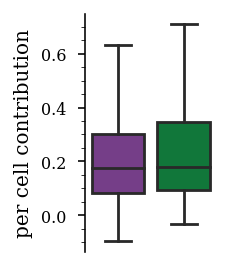

In [8]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))


keep_idx = (results_df.n_replay > 30) & (results_df.deepSuperficial != "middle")

sns.boxplot(x="deepSuperficial", y="per_cell_contribution",hue_order=group_colors.keys(),
            data=results_df[keep_idx],showfliers=False)

# sns.stripplot(x="deepSuperficial", y="per_cell_contribution",hue_order=group_colors.keys(),
#             data=results_df[keep_idx],color="k",s=2,alpha=0.5)
            
plt.ylabel("per cell contribution")
# plt.ylim(0.001,2)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# plt.gca().invert_yaxis()
# plt.yscale("log")
ax.set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "per_cell_contribution.svg"),
    dpi=300,
    bbox_inches="tight",
)

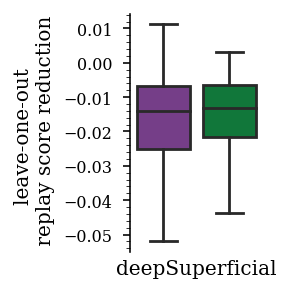

In [9]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))


keep_idx = (results_df.n_replay > 30) & (results_df.deepSuperficial != "middle")

sns.boxplot(x="deepSuperficial", y="avg_left_out_score",hue_order=group_colors.keys(),
            data=results_df[keep_idx],showfliers=False)

# sns.stripplot(x="deepSuperficial", y="avg_left_out_score",hue_order=group_colors.keys(),
#             data=results_df[keep_idx],color="k",s=2)
plt.ylabel("leave-one-out \n replay score reduction")

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)

In [10]:
results_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_score_reduction.csv")
